<a href="https://colab.research.google.com/github/Vicky-0222/NLP/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Решение задач Классификация Кластеризация Генерация

### Collect data

Установка и импорт необходимых библиотек

In [24]:
!pip install pymorphy3

In [25]:
import pandas as pd
import numpy as np
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Загрузка данных

In [27]:
df = pd.read_csv('/content/movie.csv')

In [28]:
texts = df['overview']
categories = df['name']

Визуализация

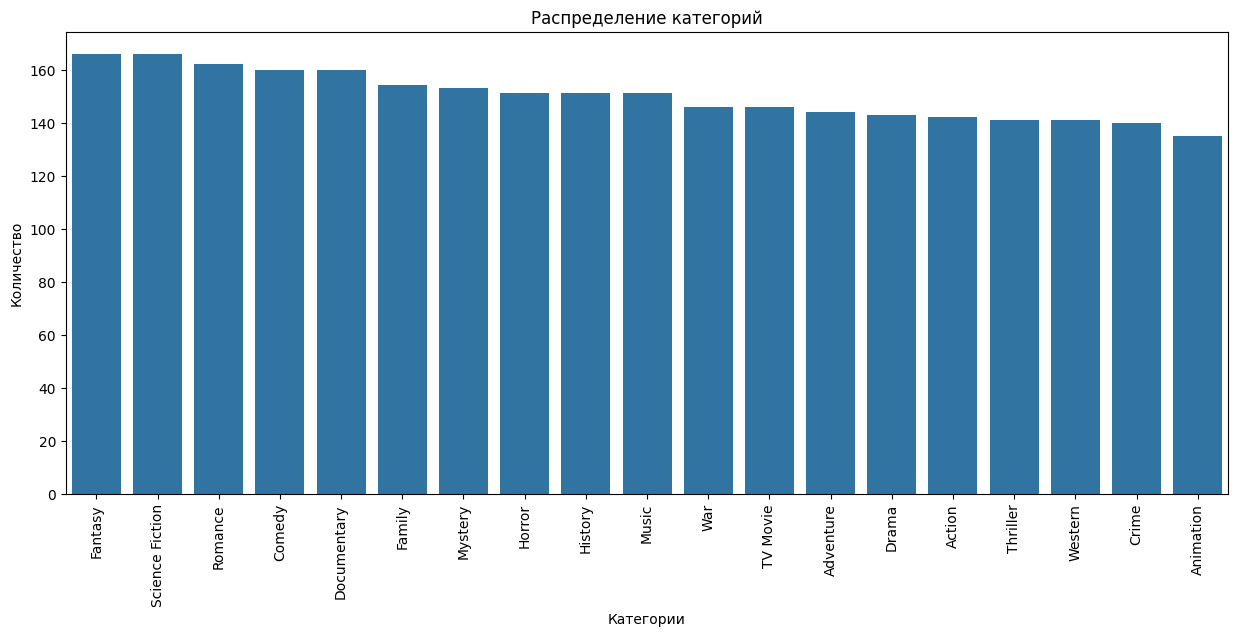

In [29]:
plt.figure(figsize=(15, 6))
sns.countplot(x='name', data=df, order=categories.value_counts().index)
plt.title('Распределение категорий')
plt.xlabel('Категории')
plt.xticks(rotation=90)
plt.ylabel('Количество')
plt.show()

### Prepare data

Токенизация и лемматизация

In [30]:
morph = pymorphy3.MorphAnalyzer()

def preprocessing(text):
    # токенизация
    tokens = word_tokenize(text.lower())
    # лемматизация
    lemmatized_tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens if token.isalpha()]

    return ' '.join(lemmatized_tokens)

In [31]:
preprocessed_texts = texts.apply(preprocessing)
print(preprocessed_texts)

0       firemen brothers brian and stephen mccaffrey b...
1       factory worker doug quaid takes a virtual vaca...
2       milan italy santo russo a boy of calabrian ori...
3       zed is an american who travels to paris to mee...
4       a former marine confronts corruption in a smal...
                              ...                        
2995    in the ruins of berlin a boy is left to his ow...
2996    a young man is afraid of asking for sex tips t...
2997    in this feature film based on the hit animated...
2998    an unsuspecting disenchanted man finds himself...
2999    alex an immigrant from ukraine comes to canada...
Name: overview, Length: 3000, dtype: object


Векторизация через TFIDF

In [32]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(preprocessed_texts)

Кластеризация с помощью Spectral Clustering

In [33]:
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

In [34]:
spectral = SpectralClustering(
    n_clusters=5,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
labels = spectral.fit_predict(X_scaled)

Визуализация

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

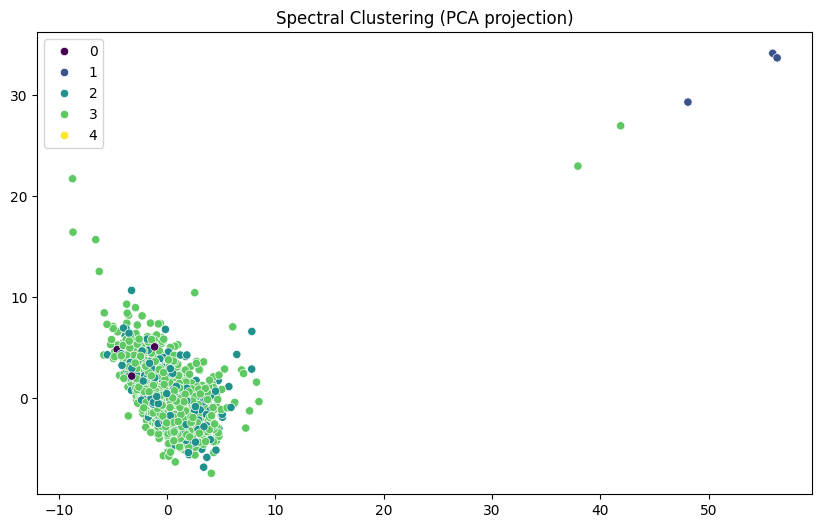

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels,
    palette='viridis',
    legend='full'
)
plt.title('Spectral Clustering (PCA projection)')
plt.show()

### Сравнение результатов с реальной разметкой

In [39]:
if len(set(labels)) > 1:
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Все точки в одном кластере!")

# Анализ результатов
df['cluster'] = labels
for cluster in sorted(df['cluster'].unique()):
    print(f"\n Кластер {cluster}:")
    print(df[df['cluster'] == cluster]['name'].value_counts().head(5))

Silhouette Score: -0.124

 Кластер 0:
name
Horror       3
Family       3
History      3
Crime        2
Animation    2
Name: count, dtype: int64

 Кластер 1:
name
Romance            1
Science Fiction    1
Western            1
Name: count, dtype: int64

 Кластер 2:
name
Documentary        45
TV Movie           44
Romance            43
History            42
Science Fiction    41
Name: count, dtype: int64

 Кластер 3:
name
Mystery            127
Fantasy            127
Science Fiction    124
Comedy             122
Music              121
Name: count, dtype: int64

 Кластер 4:
name
Drama     1
Family    1
War       1
Name: count, dtype: int64


### Разделение на train, test и val выборки

In [38]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(train_data)
print(test_data)
print(val_data)


                title                                           overview  \
611     Anna Karenina  In Imperial Russia, Anna, the wife of the offi...   
530    50 First Dates  Henry is a player skilled at seducing women. B...   
2787       The 'Burbs  When secretive new neighbors move in next door...   
49    Stealing Beauty  Lucy Harmon, an American teenager is arriving ...   
1883            Cyrus  With John's social life at a standstill and hi...   
...               ...                                                ...   
1638    Tale of Tales  The Queen of Selvascura risks everything to be...   
1095    Inland Empire  An actress’s perception of reality becomes inc...   
1130     Wolf Creek 2  Lured by the promise of an Australian holiday,...   
1294          Ghosted  Salt-of-the-earth Cole falls head over heels f...   
860    Apocalypse Now  At the height of the Vietnam war, Captain Benj...   

          name  cluster  
611      Music        3  
530   Thriller        3  
2787    F